# TPC-C Multi-Tenant in PostgreSQL

## The database is stored with loose durability guarantees on a shared local hdd

This notebook contains evaluations as presented in **Benchmarking Multi-Tenant Architectures in PostgreSQL**

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown
import seaborn as sns
from math import floor
import ast
import json
import re
import numpy as np

#import dbmsbenchmarker
#import bexhoma
from bexhoma import collectors

%matplotlib inline

# Functions for Nice Plots

In [2]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    if b_plot_save:
        filename = filename_prefix + sanitize_filename(title) + ".png"    
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    if b_plot_save:
        filename = filename_prefix + sanitize_filename(title) + ".png"    
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_lines(df, y, title):
    plt.figure(figsize=(10, 6))

    # Consistent colors per type
    palette = {
        'container': '#66c2a5',
        'database': '#fc8d62',
        'schema': '#8da0cb'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot lineplot grouped by num_tenants and colored by type

    ax = sns.lineplot(
        data=df.reset_index(),
        x="timestamp",
        y=y,
        hue="type",
        hue_order=hue_order,
        style="num_tenants",          # different line styles per type
        markers=False,          # markers at points
        dashes=True,
        estimator=None,   # plot raw data without aggregation
        errorbar=None,
        #fill=False,         # <- this disables area fill!
        #ci=None,
        palette=palette
    )

    # Axis labels and title
    plt.title(title, fontsize=24)
    plt.xlabel("Second", fontsize=18)
    #plt.ylabel(y, fontsize=18)
    ax.set(ylabel=None)
    ax.tick_params(axis='both', labelsize=16)

    # Legend formatting
    plt.legend(fontsize=16, title_fontsize=18)
    
    # Save
    if b_plot_save:
        filename = filename_prefix + "_" + title.replace(" ", "_") + ".png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

#print("Seaborn version:", sns.__version__)

# Collect Results

In [3]:
path = r"/home/perdelt/benchmarks"
filename_prefix = "tpcc_local_"
b_plot_save = False

In [4]:
codes = ['1750956047', '1750957727', '1750959412', '1750961088', '1750962809', '1750964529', '1750966420', '1750968232', '1750970079', '1750972038', '1750973923', '1750975831', '1750977897', '1750979870', '1750981727', '1750983880', '1750985921', '1750987946', '1750990114', '1750992266', '1750994292', '1750996702', '1750998931', '1751001062', '1751003657', '1751005982', '1751008063', '1751010748', '1751013150', '1751015378']
# '1750949971', 
codes

['1750956047',
 '1750957727',
 '1750959412',
 '1750961088',
 '1750962809',
 '1750964529',
 '1750966420',
 '1750968232',
 '1750970079',
 '1750972038',
 '1750973923',
 '1750975831',
 '1750977897',
 '1750979870',
 '1750981727',
 '1750983880',
 '1750985921',
 '1750987946',
 '1750990114',
 '1750992266',
 '1750994292',
 '1750996702',
 '1750998931',
 '1751001062',
 '1751003657',
 '1751005982',
 '1751008063',
 '1751010748',
 '1751013150',
 '1751015378']

In [5]:
collect = collectors.benchbase(path, codes)

# Get all Metrics Metadata

In [6]:
code = codes[0]
evaluate = collect.get_evaluator(code)
collect.df_metrics = collect.get_metrics(evaluate)
# patch one metric - it is a counter
collect.df_metrics.loc[collect.df_metrics["title"] == "CPU Util [s]", "metric"] = "counter"

#collect.df_metrics

,title,active,type,metric
total_cpu_memory,CPU Memory [MiB],True,cluster,
total_cpu_memory_cached,CPU Memory Cached [MiB],True,cluster,
total_cpu_util,CPU Util [%],True,cluster,
total_cpu_util_max,CPU Util Max [%],True,cluster,
total_cpu_throttled,CPU Throttle [%],True,cluster,
total_cpu_util_others,CPU Util Others [%],True,cluster,
total_cpu_util_s,CPU Util [s],True,cluster,counter
total_cpu_util_user_s,CPU Util User [s],True,cluster,
total_cpu_util_sys_s,CPU Util Sys [s],True,cluster,
total_cpu_throttled_s,CPU Throttle [s],True,cluster,


# Performance Results per Tenant

In [7]:
df_performance = collect.get_performance_all_single()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

#df_performance

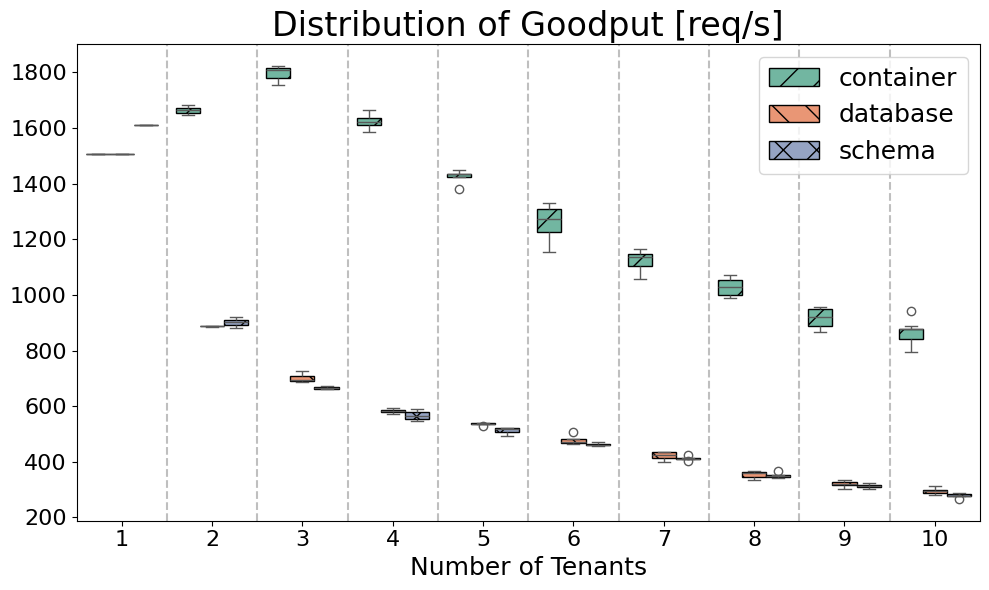

In [8]:
plot_boxplots(df_performance_first, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

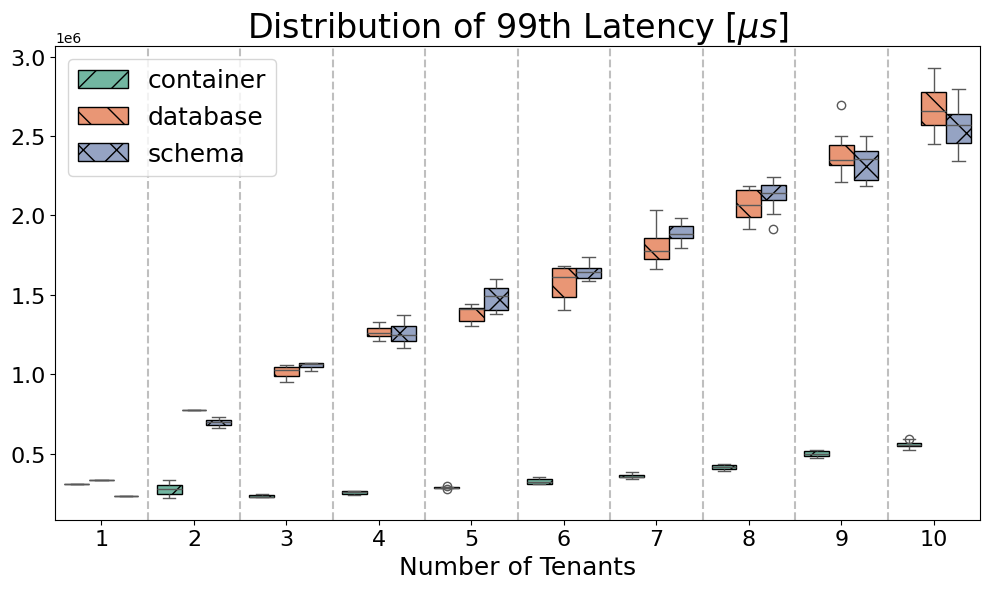

In [9]:
plot_boxplots(df_performance_first, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')


# Performance Results per Total

In [10]:
df_performance = collect.get_performance_all()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance.dropna(inplace=True)

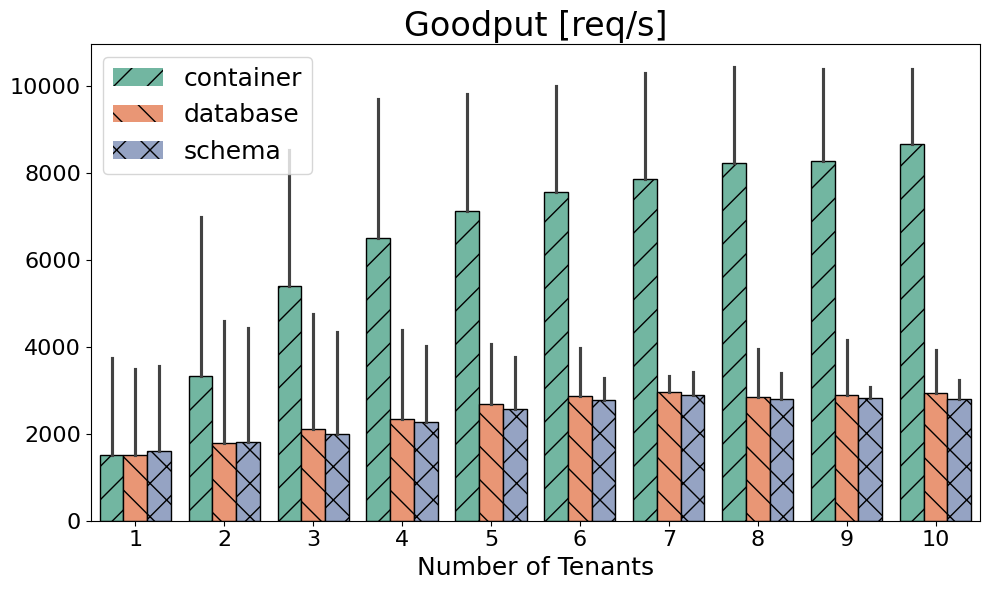

In [11]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

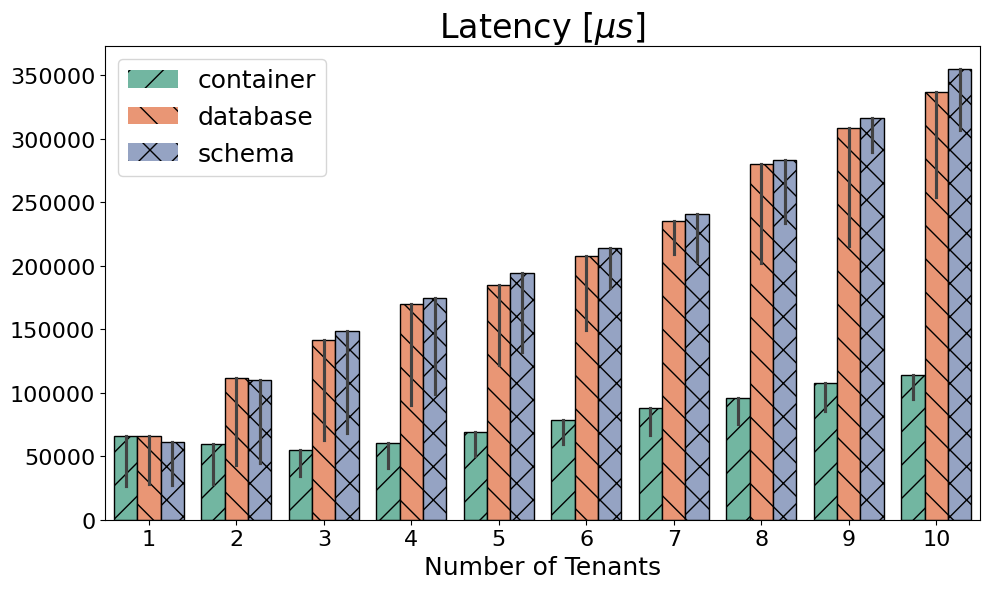

In [12]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

In [13]:
df_performance = collect.get_loading_time_max_all()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

#df_performance

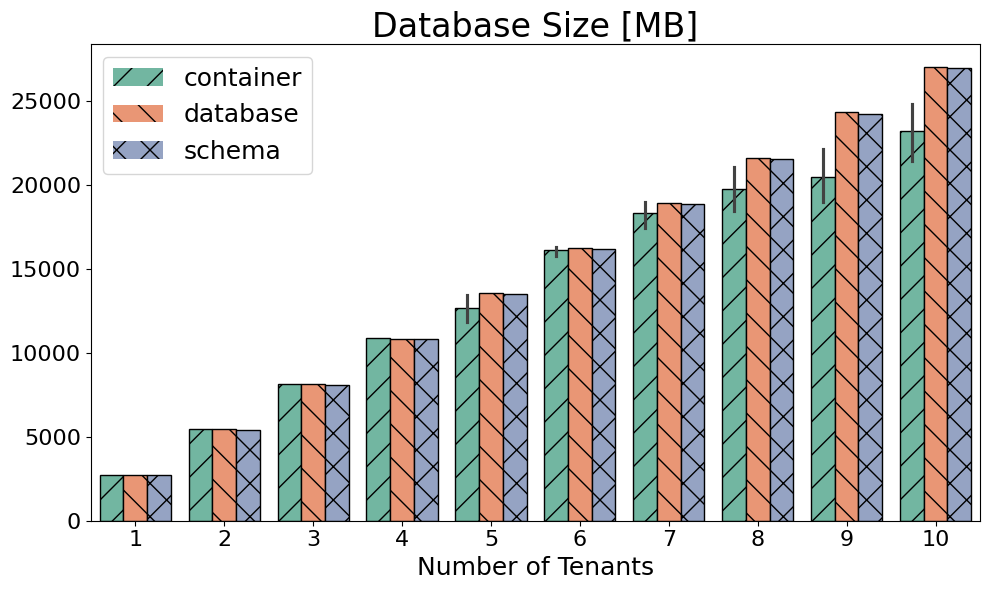

In [14]:
df_performance_first = df_performance[df_performance['client'] == '1']
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

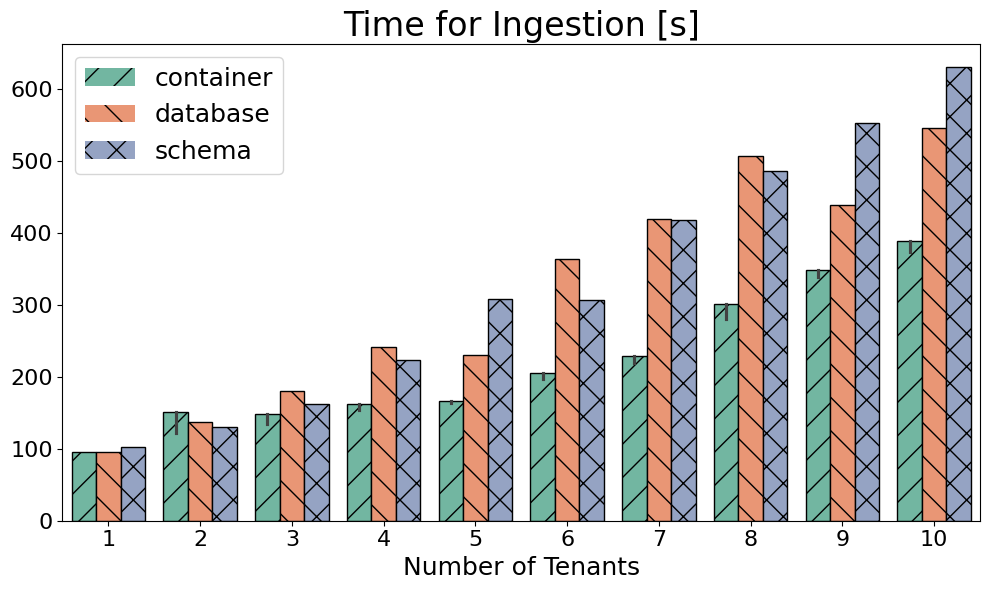

In [15]:
plot_bars(df_performance, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

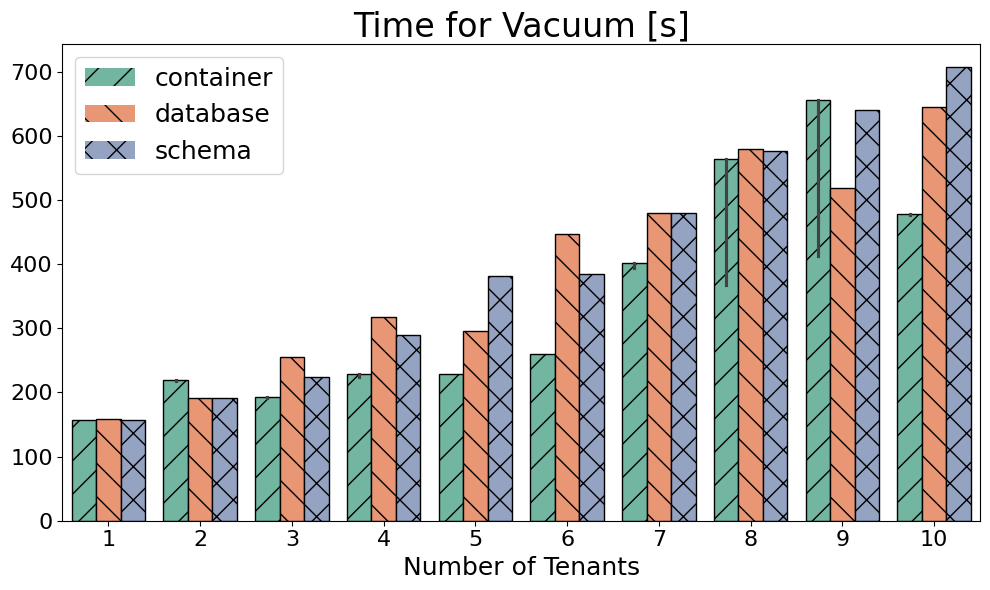

In [16]:
plot_bars(df_performance, y='time_check', title='Time for Vacuum [s]', estimator='max')

# Hardware Monitoring for Benchmarking Phase

In [17]:
df_performance = collect.get_monitoring_all(type="stream")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

#df_performance.T

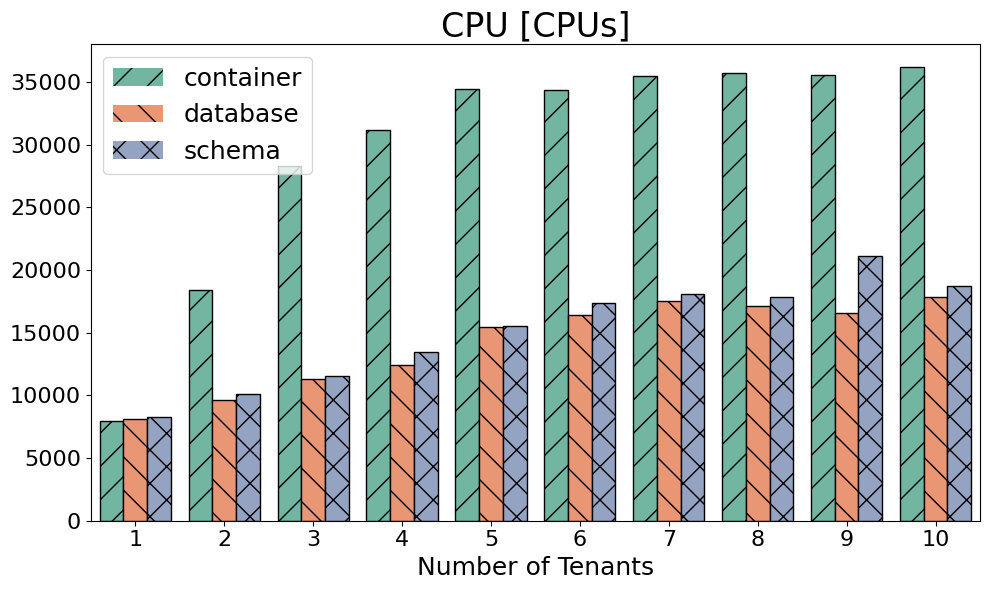

In [18]:
plot_bars(df_performance_first, y='CPU Util [s]', title='CPU [CPUs]', estimator='mean')

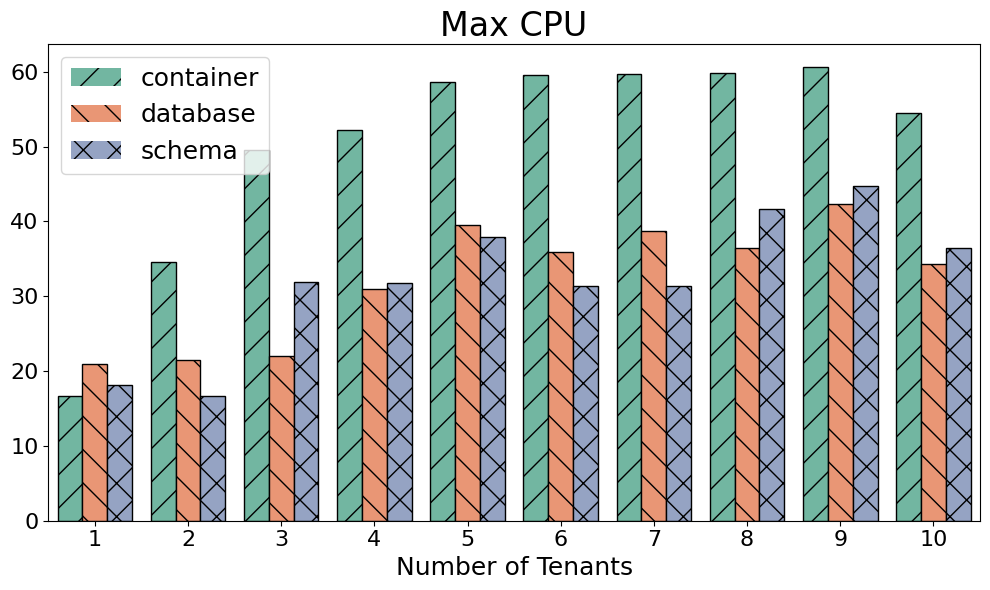

In [19]:
metric = 'total_cpu_util'

df_performance_series = collect.get_monitoring_timeseries_all(metric)
df_performance_first = df_performance_series[df_performance_series['client']=='1']
df_performance_second = df_performance_series[df_performance_series['client']=='2']

df_agg = (
    df_performance_first.groupby(["client", "type", "num_tenants"])["value"]
      .max()
      .reset_index()
)
plot_bars(df_agg, y='value', title='Max CPU', estimator='max')
#df_agg

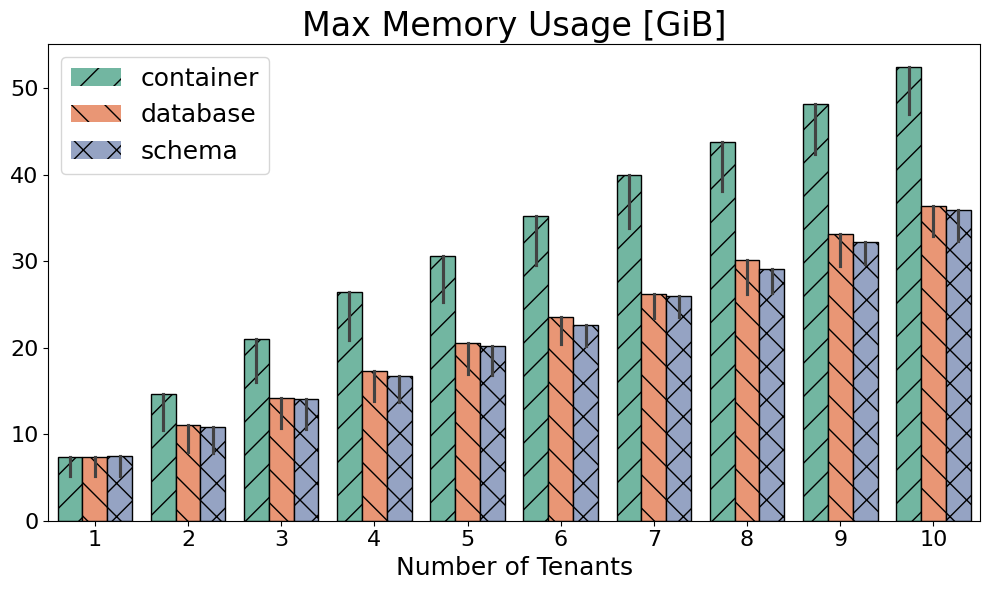

In [20]:
metric = 'total_cpu_memory'

df_performance_series = collect.get_monitoring_timeseries_all(metric)

df_agg = (
    df_performance_series.groupby(["client", "type", "num_tenants"])["value"]
      .max()
      .reset_index()
)
df_agg['value'] = df_agg['value'] / 1024.
plot_bars(df_agg, y='value', title='Max Memory Usage [GiB]', estimator='max')

#plot_bars(df_performance, y='Memory Usage [MiB]', title='Average Memory Usage [MiB]', estimator='max')
#plot_bars(df_performance, y='CPU Memory [MiB]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [21]:
client = '1'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'code', 'client'], how='inner')
#merged_df['I_Lat'] = 1./merged_df['E_Lat']
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU Util [s]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU Util [s]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['CPU Memory [MiB]']
#merged_df

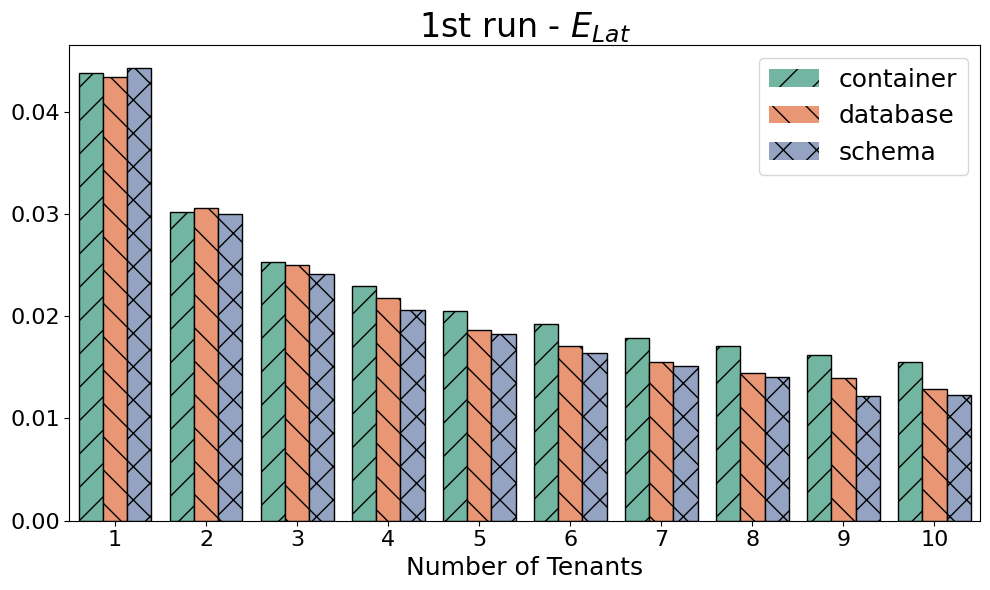

In [22]:
plot_bars(merged_df, y='E_Lat', title='1st run - $E_{Lat}$', estimator='max')

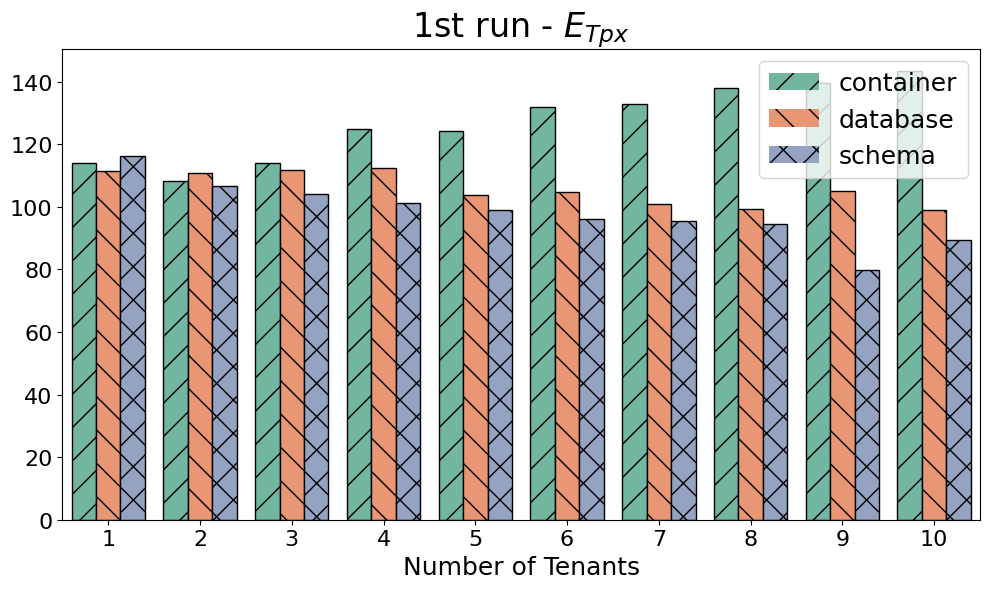

In [23]:
plot_bars(merged_df, y='E_Tpx', title='1st run - $E_{Tpx}$', estimator='max')

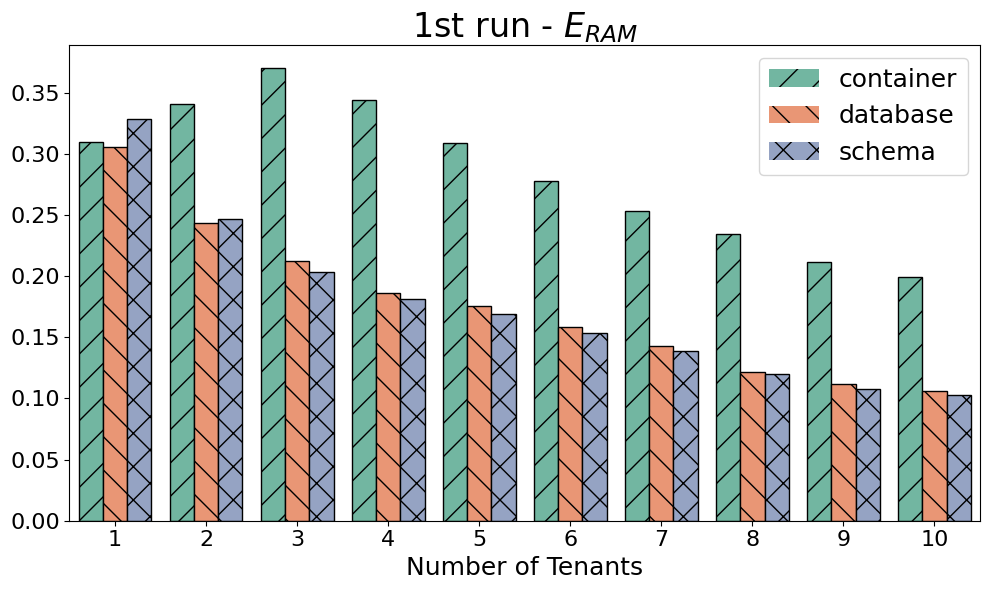

In [24]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='max')

In [25]:
client = '2'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants', 'code', 'client'], how='inner')
#merged_df['I_Lat'] = 1./merged_df['E_Lat']
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU Util [s]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU Util [s]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['CPU Memory [MiB]']
#merged_df

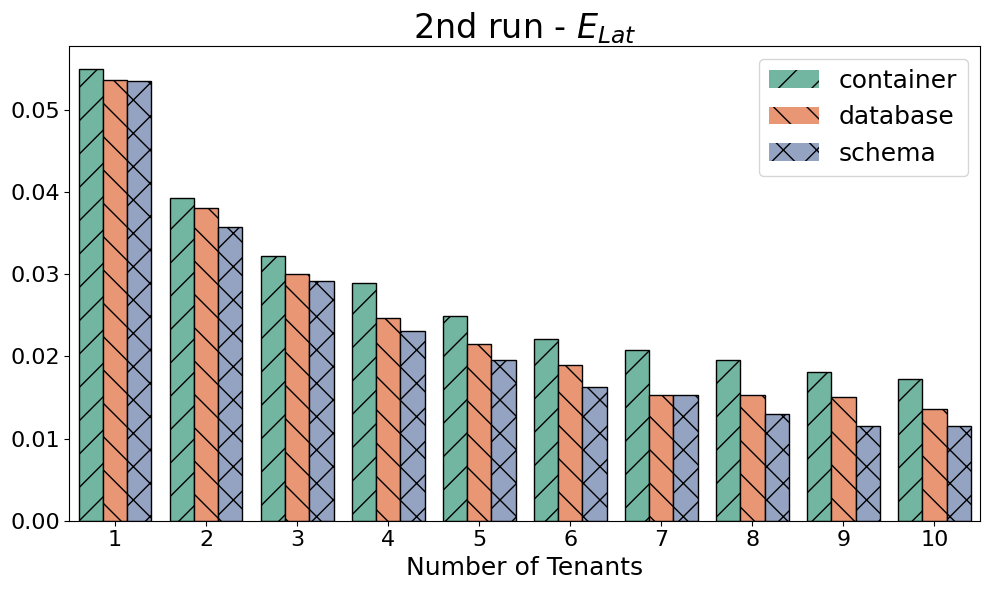

In [26]:
plot_bars(merged_df, y='E_Lat', title='2nd run - $E_{Lat}$', estimator='max')

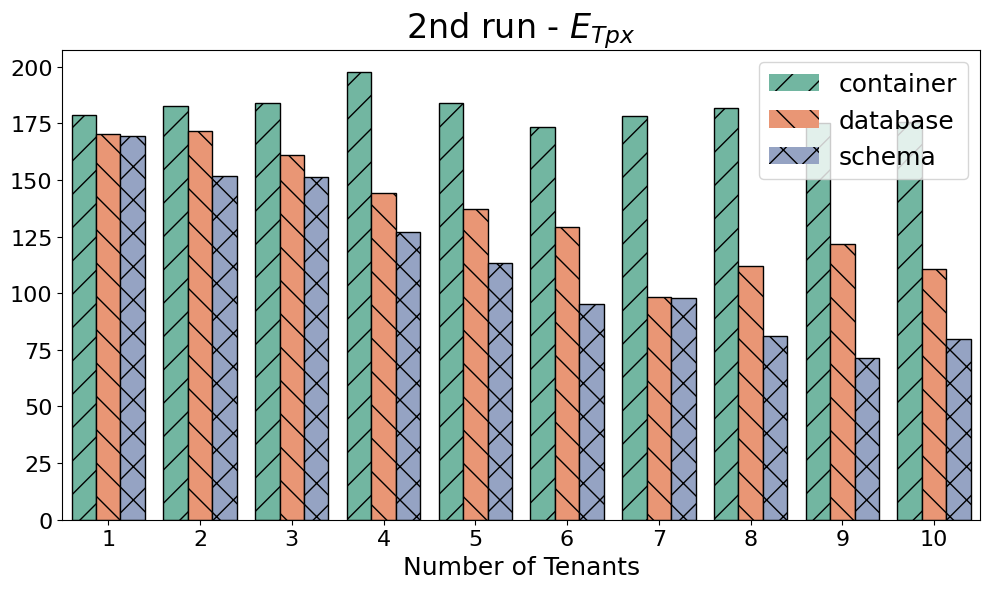

In [27]:
plot_bars(merged_df, y='E_Tpx', title='2nd run - $E_{Tpx}$', estimator='max')

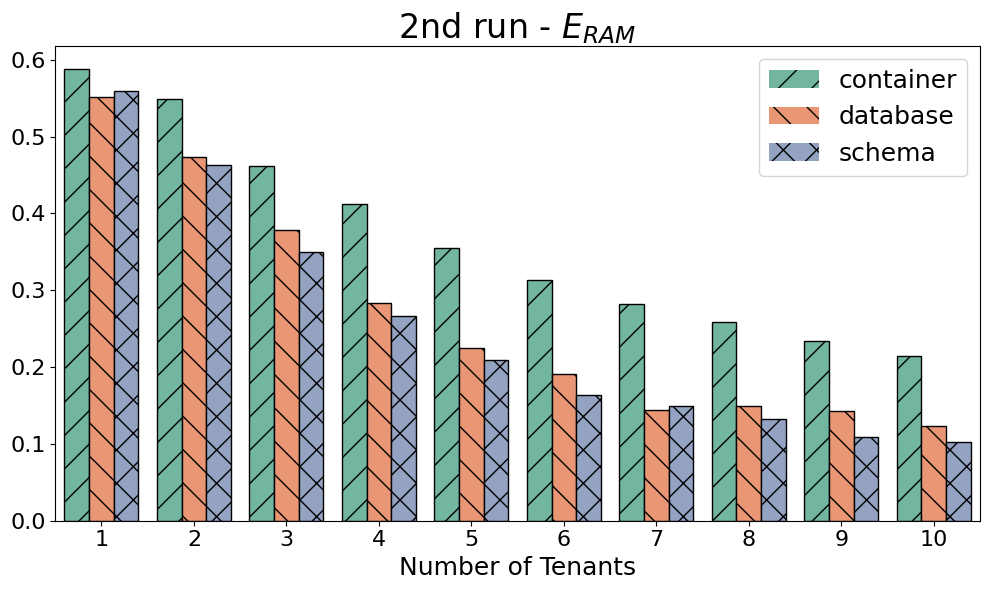

In [28]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [29]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [30]:
#zip_all_results()